# Bayesian A/B Test

In [39]:
import numpy as np

## Generate some data

In [181]:
blue_button_click_probability = .75
red_button_click_probability = .7

In [182]:
blue_button_clicks = np.random.binomial(n=1, p=blue_button_click_probability, size=250).astype(bool)

In [198]:
red_button_clicks = np.random.binomial(n=1, p=red_button_click_probability, size=250).astype(bool)

In [183]:
blue_button_clicks.mean()

0.78800000000000003

In [199]:
red_button_clicks.mean()

0.65200000000000002

### Create DataFrame

In [200]:
blue_button_data = pd.DataFrame({'button_clicked': blue_button_clicks, 'button_color': 'blue'})

In [201]:
red_button_data = pd.DataFrame({'button_clicked': red_button_clicks, 'button_color': 'red'})

In [202]:
data = pd.concat([blue_button_data, red_button_data])

### For the red button

#### Value counts

In [204]:
data[data['button_color'] == 'red']['button_clicked'].value_counts()

True     163
False     87
Name: button_clicked, dtype: int64

#### Click frequency

In [206]:
163 / 250

0.652

### For the blue button

#### Value counts

In [207]:
data[data['button_color'] == 'blue']['button_clicked'].value_counts()

True     197
False     53
Name: button_clicked, dtype: int64

#### Click frequency

In [208]:
197 / 250

0.788

## Bayesian Inference

In [209]:
import pymc as pm

### Define random variables

In [210]:
p_click_red_button = pm.Uniform('p_click_red_button', lower=0, upper=1)
p_click_blue_button = pm.Uniform('p_click_blue_button', lower=0, upper=1)

@pm.deterministic
def relative_increase(p_click_red_button=p_click_red_button, p_click_blue_button=p_click_blue_button):
    return (p_click_red_button/p_click_blue_button) - 1

obs_red_button = pm.Bernoulli('obs_red_button', p_click_red_button, value=red_button_clicks, observed=True)
obs_blue_button = pm.Bernoulli('obs_blue_button', p_click_blue_button, value=blue_button_clicks, observed=True)

## Fit a model

In [211]:
mcmc = pm.MCMC([p_click_red_button, p_click_blue_button, relative_increase, obs_red_button, obs_blue_button])
mcmc.sample(20000, 10000)

 [-----------------100%-----------------] 20000 of 20000 complete in 2.0 sec

## Visualize results

In [212]:
%matplotlib inline

import matplotlib.pyplot as plt

### Individual posterior distributions

In [213]:
def plot_individual_posteriors(p_click_red_button_samples, p_click_blue_button_samples):
    plt.figure(figsize=(14.5, 6))
    ax = plt.subplot(211)

    plt.xlim(0, 1)
    plt.hist(p_click_red_button_samples, histtype='stepfilled', bins=25, alpha=0.85,
             label="Posterior of p_click_red_button", color="#A60628", normed=True)
    plt.legend(loc="upper left")
    plt.title("Posterior Distributions of p_click_red_button, p_click_blue_button")

    ax = plt.subplot(212)

    plt.xlim(0, 1)
    plt.hist(p_click_blue_button_samples, histtype='stepfilled', bins=25, alpha=0.85,
             label="Posterior of p_click_blue_button", color="#467821", normed=True)
    plt.legend(loc="upper left")

In [214]:
p_click_red_button_samples = mcmc.trace("p_click_red_button")[:]
p_click_blue_button_samples = mcmc.trace("p_click_blue_button")[:]

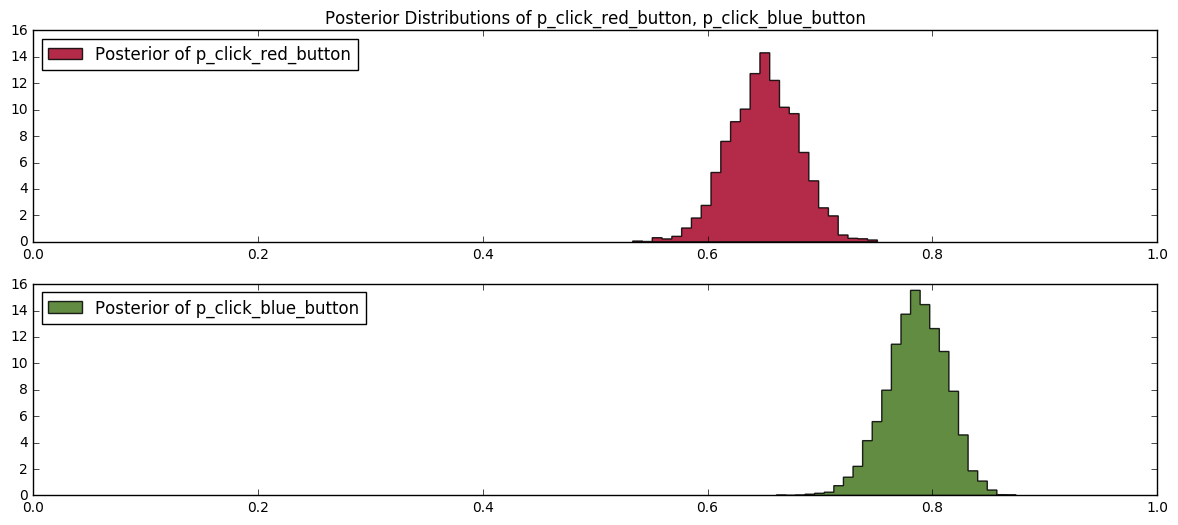

In [215]:
plot_individual_posteriors(p_click_red_button_samples, p_click_blue_button_samples)

### Relative increase distribution

In [162]:
def plot_relative_increase_posterior(relative_increase_samples):
    plt.figure(figsize=(14.5, 6))

    plt.hist(relative_increase_samples, histtype='stepfilled', bins=30, alpha=0.85,
             label=r"""$\frac{p_{click\_red}}{p_{click\_blue}} - 1$""", color="#7A68A6", normed=True)
    plt.axvline(0, color='k', linestyle='--')
    plt.title("""Relative Increase In Button Clicks, Red Button vs. Blue Button""", size=20)
    plt.legend(loc="upper right", fontsize=35)
    plt.tight_layout()

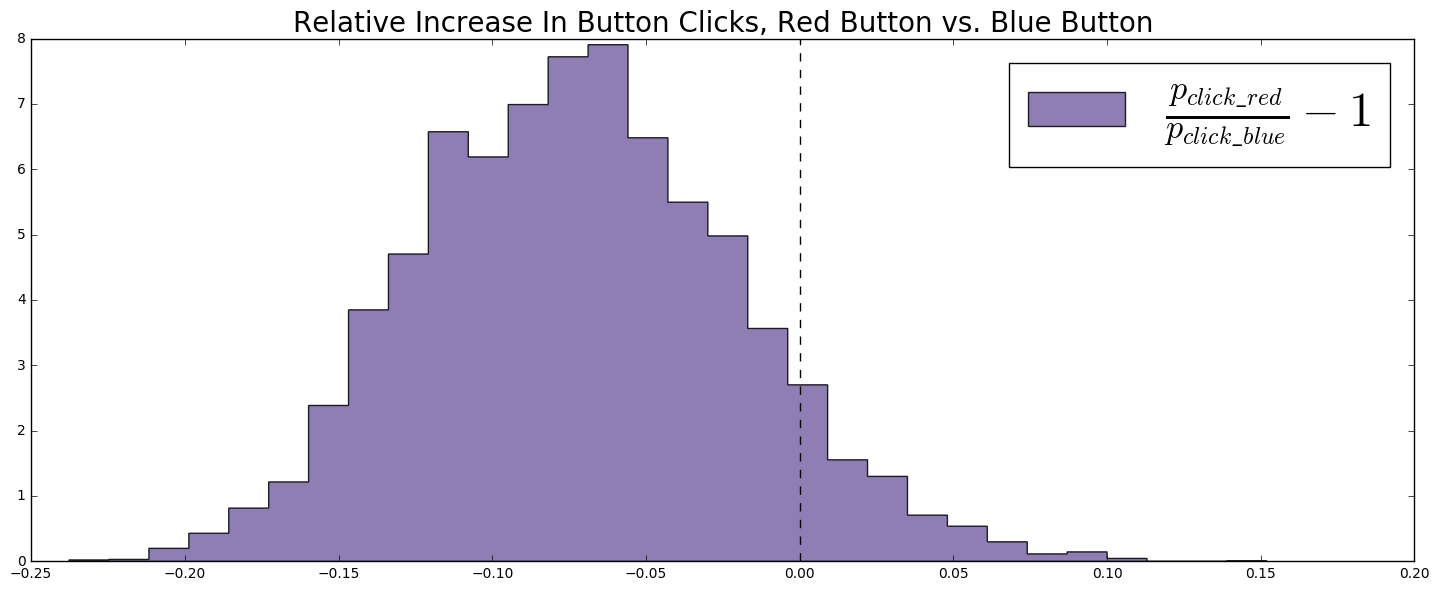

In [163]:
relative_increase_samples = mcmc.trace("relative_increase")[:]

plot_relative_increase_posterior(relative_increase_samples)

In [165]:
(relative_increase_samples < 0).mean()

0.91779999999999995

In [166]:
fifth_percentile = np.percentile(relative_increase_samples, 5)

In [167]:
fifth_percentile

-0.15423426532252574

In [168]:
ninety_fifth_percentile = np.percentile(relative_increase_samples, 95)

In [169]:
ninety_fifth_percentile

0.015239963124848765

In [171]:
(relative_increase_samples > .05).mean()

0.014